# Artificial Intelligence Nanodegree

## Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this IPython notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Use a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 6](#step6): Write your Algorithm
* [Step 7](#step7): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

In the code cell below, we import a dataset of dog images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

Using TensorFlow backend.


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [2]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---
<a id='step1'></a>
## Step 1: Detect Humans

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 3


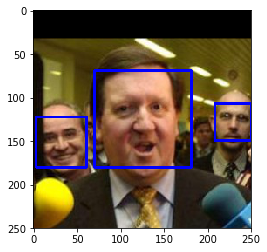

In [3]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[3])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [4]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 

In [5]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]
# Do NOT modify the code above this line.

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.

humans_detected = 0;
dogs_detected = 0;

for file_idx in range(100):
    if face_detector(human_files_short[file_idx]):
        humans_detected += 1
        
    if face_detector(dog_files_short[file_idx]):
        dogs_detected += 1
        
print('Percentage of humans detected: {}%'.format(humans_detected))
print('Percentage of dogs detected: {}%'.format(dogs_detected))

Percentage of humans detected: 99%
Percentage of dogs detected: 11%


__Question 2:__ This algorithmic choice necessitates that we communicate to the user that we accept human images only when they provide a clear view of a face (otherwise, we risk having unneccessarily frustrated users!). In your opinion, is this a reasonable expectation to pose on the user? If not, can you think of a way to detect humans in images that does not necessitate an image with a clearly presented face?

__Answer:__

We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on each of the datasets.

---

For this exercise I intend to use the datagen facilities of the Keras framework, and for that I'll perform the following step, which will also be well commented:

0. Join the vectors of human and dog images
0. Separate the vectors into training, validate and test sets
0. Use a scramble function to scramble the sets
0. Create, train and use the network
0. Evaluate the code based on Keras loss metric

__Defining a scramble function:__

In [6]:
def scramble_func(x, y):
    '''
    This function takes 2 corrilated vectors as input, i.e. data and label vectors,
    and returns the scrambled versions of theses vectors
    '''
    shufled_idx = []
    scrambled_x = []
    scrambled_y = []
    
    for idx in range(len(x)):
        shufled_idx.append(idx)
        
    random.shuffle(shufled_idx)
    
    for idx in shufled_idx:
        scrambled_x.append(x[idx])
        scrambled_y.append(y[idx])
        
    return scrambled_x, scrambled_y

#### Testing the scramble function

In [7]:
# The first 13 entries in the array were humans with with great IQ and the last ones are famous dogs
x_train = [
    'Charles Dickens', 'Raphael', 'Michael Faraday', 'Baruch Spinoza',
    'Michelangelo', 'Desiderius Erasmus', 'Rene Descartes', 'Galileo Galilei',
    'John Stuart Mill', 'Gottfried Wilhelm Leibnitz', 'Isaac Newton', 'Leonardo Da Vinci',
    'Johann Wolfgang von Goethe', 'Boo', 'Maru', 'Tuna', 'Marnie', 'Minnie', 'Max'
]

y_train = [1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0]

# 1 means human and 0 means no human
set_template = {
    'Charles Dickens': 1,
    'Raphael': 1,
    'Michael Faraday': 1,
    'Baruch Spinoza': 1,
    'Michelangelo': 1,
    'Desiderius Erasmus': 1,
    'Rene Descartes': 1,
    'Galileo Galilei': 1,
    'John Stuart Mill': 1,
    'Gottfried Wilhelm Leibnitz': 1,
    'Isaac Newton': 1,
    'Leonardo Da Vinci': 1,
    'Johann Wolfgang von Goethe': 1,
    'Boo': 0,
    'Maru': 0,
    'Tuna': 0,
    'Marnie': 0,
    'Minnie': 0,
    'Max': 0    
}

# Printing original and scrambled vectors
scrambled_x, scrambled_y = scramble_func(x_train, y_train)
print('Original vectors:')
print(x_train, y_train, '\n')
print('Scrambled vectors:')
print(scrambled_x, scrambled_y, '\n')

# Here we traverse the scrambled vector and check for mistakes
mistakes = 0
for idx in range(len(x_train)):
    name = scrambled_x[idx]
    label = scrambled_y[idx]
    if set_template[name] != label:
        mistakes += 1
        
print('Found {} mistake(s) in the scrambled sets'.format(mistakes))

Original vectors:
['Charles Dickens', 'Raphael', 'Michael Faraday', 'Baruch Spinoza', 'Michelangelo', 'Desiderius Erasmus', 'Rene Descartes', 'Galileo Galilei', 'John Stuart Mill', 'Gottfried Wilhelm Leibnitz', 'Isaac Newton', 'Leonardo Da Vinci', 'Johann Wolfgang von Goethe', 'Boo', 'Maru', 'Tuna', 'Marnie', 'Minnie', 'Max'] [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0] 

Scrambled vectors:
['Boo', 'Michael Faraday', 'Minnie', 'Rene Descartes', 'Isaac Newton', 'Galileo Galilei', 'Tuna', 'Baruch Spinoza', 'Raphael', 'Leonardo Da Vinci', 'Marnie', 'Charles Dickens', 'Max', 'Johann Wolfgang von Goethe', 'John Stuart Mill', 'Gottfried Wilhelm Leibnitz', 'Michelangelo', 'Maru', 'Desiderius Erasmus'] [0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1] 

Found 0 mistake(s) in the scrambled sets


#### Loading the data

In this sections some files will be selected training, validation and testing files. These vectors will then be scrambled and then used to load the images inside the tensor, using the functions already provided in the code.

In [9]:
from keras.utils import to_categorical
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True 

# Since the first 100 images, already present in the human_short_files and dog_short_files
# will be used for testing, we must load the files in the 100th position and forward
human_files_train = human_files[100:]
dog_files_train = train_files[100:]
x_train = np.concatenate((human_files_train, dog_files_train))

# Creating the labels for the train and test sets
y_train = [1]*len(human_files_train) + [0]*len(dog_files_train)
human_test_target = to_categorical([1]*100, 2)
dog_test_target = to_categorical([0]*100, 2)

# Scrambling the training set, and then dividing it into training and validation sets
scrambled_x_train, scrambled_y_train = scramble_func(x_train, y_train)

scrambled_x_valid = scrambled_x_train[:500]
scrambled_x_train = scrambled_x_train[500:500 + 2000]

scrambled_y_valid = scrambled_y_train[:500]
scrambled_y_train = scrambled_y_train[500:500 + 2000]

scrambled_y_train = to_categorical(scrambled_y_train, 2)
scrambled_y_valid = to_categorical(scrambled_y_valid, 2)

# As usual, normalizing the 8 bits depth images. 'paths_to_tensor' is the already provided function
# To use this function I executed its corresponded cell before this one
human_train_tensors = paths_to_tensor(scrambled_x_train).astype('float32')/255
human_valid_tensors = paths_to_tensor(scrambled_x_valid).astype('float32')/255
human_test_tensors = paths_to_tensor(human_files_short).astype('float32')/255
dog_test_tensors = paths_to_tensor(dog_files_short).astype('float32')/255

100%|██████████| 100/100 [00:00<00:00, 138.07it/s]


#### Loading pretrained models and setting up datagens

In this section I'll load the VGG16 network without the top layers and train may own top layer. To improve performance I'll use data augmentation.

In [10]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator

# Creating datagens for the training and validation sets
human_train_datagen = ImageDataGenerator(
                    rotation_range=0.2,
                    width_shift_range=0.2,
                    height_shift_range=0.2,
                    shear_range=0.2,
                    zoom_range=0.2,
                    horizontal_flip=True,
                    vertical_flip=True)

human_valid_datagen = ImageDataGenerator(
                    rotation_range=0.2,
                    width_shift_range=0.2,
                    height_shift_range=0.2,
                    shear_range=0.2,
                    zoom_range=0.2,
                    horizontal_flip=True,
                    vertical_flip=True)

human_train_datagen.fit(human_train_tensors)
human_valid_datagen.fit(human_valid_tensors)

# Loading the VGG16 network
vgg16_model = VGG16(include_top=False, weights='imagenet')
vgg16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

#### Generating the bottleneck features

Here I generate the bottleneck features the training, validation and testing sets. This sets will then be used to train the top layers.

In [11]:
batch_size = 16

# Generating training and validation bottleneck with data augmentation
datagen_flow = human_train_datagen.flow(x=human_train_tensors, y=scrambled_y_train, batch_size=batch_size, shuffle=False)
human_bottleneck_train = vgg16_model.predict_generator(datagen_flow, human_train_tensors.shape[0] / batch_size)

datagen_flow = human_valid_datagen.flow(x=human_valid_tensors, y=scrambled_y_valid, batch_size=batch_size, shuffle=False)
human_bottleneck_valid = vgg16_model.predict_generator(datagen_flow, human_valid_tensors.shape[0] / batch_size)

# Test bottleneck generation
human_bottleneck_test = vgg16_model.predict(human_test_tensors)
dog_bottleneck_test = vgg16_model.predict(dog_test_tensors)

# Saving the results, so MAYBE I can use the data for something else :)
np.save(open('bottleneck_features/human_bottleneck_train.npy', 'wb'), human_bottleneck_train)
np.save(open('bottleneck_features/human_bottleneck_valid.npy', 'wb'), human_bottleneck_valid)
np.save(open('bottleneck_features/human_bottleneck_test.npy', 'wb'), human_bottleneck_test)
np.save(open('bottleneck_features/dog_bottleneck_test.npy', 'wb'), dog_bottleneck_test)

# Printing the results just for checking
print('Human bottleneck train features shape:{}'.format(human_bottleneck_train.shape))
print('Human bottleneck valid features shape:{}'.format(human_bottleneck_valid.shape))
print('Human bottleneck test features shape:{}'.format(human_bottleneck_test.shape))
print('Dog bottleneck test features shape:{}'.format(dog_bottleneck_test.shape))

Human bottleneck train features shape:(2000, 7, 7, 512)
Human bottleneck valid features shape:(500, 7, 7, 512)
Human bottleneck test features shape:(100, 7, 7, 512)
Dog bottleneck test features shape:(100, 7, 7, 512)


#### Creating the top layers

In [12]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D

# Here I used global average pooling the decrease the number of parameters
# I've put this dense layer to classify the features comming from the VGG16,
# and then used a softmax dense layer to classify just the 2 that I'm interested.
# Since the labels vectors has dimension 2 due to the 1 hot enconding, I had to
# add 2 perceptrons to this layer.
human_model = Sequential()
human_model.add(GlobalAveragePooling2D(input_shape=human_bottleneck_train.shape[1:]))
human_model.add(Dense(256, activation='relu'))
human_model.add(Dropout(0.3))
human_model.add(Dense(2, activation='softmax'))

human_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
human_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 514       
Total params: 131,842
Trainable params: 131,842
Non-trainable params: 0
_________________________________________________________________


#### Training the top layer

In [13]:
from keras.callbacks import ModelCheckpoint

# Setting up the checkpointer to save the best weights
checkpointer = ModelCheckpoint(filepath='saved_models/humanvgg16.weights.best.hdf5', verbose=1, 
                               save_best_only=True)
# Training the top layers with 100 epochs
human_model.fit(human_bottleneck_train, scrambled_y_train, epochs=100, 
                validation_data=(human_bottleneck_valid, scrambled_y_valid),
                callbacks=[checkpointer], verbose=2, shuffle=True)

# Loading the best weights to the top layers
human_model.load_weights('saved_models/humanvgg16.weights.best.hdf5')

Train on 2000 samples, validate on 500 samples
Epoch 1/100
Epoch 00000: val_loss improved from inf to 0.21952, saving model to saved_models/humanvgg16.weights.best.hdf5
0s - loss: 0.2525 - acc: 0.9105 - val_loss: 0.2195 - val_acc: 0.9080
Epoch 2/100
Epoch 00001: val_loss improved from 0.21952 to 0.11167, saving model to saved_models/humanvgg16.weights.best.hdf5
0s - loss: 0.0998 - acc: 0.9660 - val_loss: 0.1117 - val_acc: 0.9580
Epoch 3/100
Epoch 00002: val_loss improved from 0.11167 to 0.07922, saving model to saved_models/humanvgg16.weights.best.hdf5
0s - loss: 0.0713 - acc: 0.9760 - val_loss: 0.0792 - val_acc: 0.9700
Epoch 4/100
Epoch 00003: val_loss improved from 0.07922 to 0.06962, saving model to saved_models/humanvgg16.weights.best.hdf5
0s - loss: 0.0530 - acc: 0.9825 - val_loss: 0.0696 - val_acc: 0.9740
Epoch 5/100
Epoch 00004: val_loss improved from 0.06962 to 0.06800, saving model to saved_models/humanvgg16.weights.best.hdf5
0s - loss: 0.0464 - acc: 0.9825 - val_loss: 0.0680 

Epoch 00063: val_loss did not improve
0s - loss: 0.0022 - acc: 0.9990 - val_loss: 0.0840 - val_acc: 0.9800
Epoch 65/100
Epoch 00064: val_loss did not improve
0s - loss: 7.0407e-04 - acc: 1.0000 - val_loss: 0.0782 - val_acc: 0.9860
Epoch 66/100
Epoch 00065: val_loss did not improve
0s - loss: 0.0010 - acc: 1.0000 - val_loss: 0.0749 - val_acc: 0.9840
Epoch 67/100
Epoch 00066: val_loss did not improve
0s - loss: 0.0010 - acc: 1.0000 - val_loss: 0.1676 - val_acc: 0.9740
Epoch 68/100
Epoch 00067: val_loss did not improve
0s - loss: 0.0016 - acc: 0.9995 - val_loss: 0.0795 - val_acc: 0.9800
Epoch 69/100
Epoch 00068: val_loss did not improve
0s - loss: 0.0010 - acc: 0.9995 - val_loss: 0.1014 - val_acc: 0.9780
Epoch 70/100
Epoch 00069: val_loss did not improve
0s - loss: 0.0039 - acc: 0.9990 - val_loss: 0.0761 - val_acc: 0.9800
Epoch 71/100
Epoch 00070: val_loss did not improve
0s - loss: 1.1760e-04 - acc: 1.0000 - val_loss: 0.0888 - val_acc: 0.9820
Epoch 72/100
Epoch 00071: val_loss did not im

#### Evaluating the model

In this section I evaluate the model with dogs and humans_files_short sets

In [14]:
human_score = human_model.evaluate(human_bottleneck_test, human_test_target, verbose=0)
dog_score = human_model.evaluate(dog_bottleneck_test, dog_test_target, verbose=0)

# The top model was trained to detect humans, so the human_score is the score of the machine in 
# detecting humans in the foto, and the dog_score is the score of the machine affirming that
# there's no human in the picture.
human_score[1] = human_score[1] * 100.00
dog_score[1] = (1 - dog_score[1]) * 100

print('%.4f%% of the images in human_files_short have a detected human.' % human_score[1])
print('%.4f%% of the images in dog_files_short have a detected human.'  % dog_score[1])

100.0000% of the images in human_files_short have a detected human.
1.0000% of the images in dog_files_short have a detected human.


#### FEELS GOOD!

<img src="http://i0.kym-cdn.com/entries/icons/facebook/000/006/077/so_good.jpg" style="width: 20%;">

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [15]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [8]:
from keras.preprocessing import image                 
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [16]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [17]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### (IMPLEMENTATION) Assess the Dog Detector

__Question 3:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 

In [18]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.

humans_detected = 0
dogs_detected = 0

for idx in range(len(human_files_short)):
    if dog_detector(human_files_short[idx]):
        humans_detected += 1
    if dog_detector(dog_files_short[idx]):
        dogs_detected += 1
        
print('{}% of the images in human_files_short have a detected dog.'.format(humans_detected))
print('{}% of the images in dog_files_short have a detected dog.'.format(dogs_detected))

0% of the images in human_files_short have a detected dog.
100% of the images in dog_files_short have a detected dog.


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 1%.  In Step 5 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

Be careful with adding too many trainable layers!  More parameters means longer training, which means you are more likely to need a GPU to accelerate the training process.  Thankfully, Keras provides a handy estimate of the time that each epoch is likely to take; you can extrapolate this estimate to figure out how long it will take for your algorithm to train. 

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun! 

### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [19]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:05<00:00, 140.07it/s]


### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        model.summary()

We have imported some Python modules to get you started, but feel free to import as many modules as you need.  If you end up getting stuck, here's a hint that specifies a model that trains relatively fast on CPU and attains >1% test accuracy in 5 epochs:

![Sample CNN](images/sample_cnn.png)
           
__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  If you chose to use the hinted architecture above, describe why you think that CNN architecture should work well for the image classification task.

__Answer:__ 

As I saw the VGG16 in the human face detection in the previous step, I realized that this network uses less filters in the beginning and this number grows towards the top layers. The results of this approach is that the machines uses less simpler filters, i.e. the filters in the beginning of the network, and more sophisticated filters on the top. So in my implementation I've tried to use this concept by placing an increasing number of filters: 64, 128 and 256. 

As pointed in the lectures, we should ideally increase the number of dimensions while deacreasing its size. To serve this purpose I placed pooling layers between the convolutional ones, which in this case have a 2x2 windows, that cuts the size of the dimensions by half of its original size.

Another problem pointed in the lectures was overfitting, and to avoid that I used dropout layers before a new convolutional. As the number of filters did increased, so the number of parameters, with that being said I also increased the chance of dropout with the number of filters.

The choice of the activation functions was totally empirical

In [20]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()

### TODO: Define your architecture.

model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=train_tensors.shape[1:]))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.1))

model.add(Conv2D(filters=128, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=256, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))

model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.35))
model.add(Dense(133, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 64)      832       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     32896     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 256)       131328    
__________

### Compile the Model

In [21]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [22]:
# Creating datagens for the training and validation sets
train_datagen = ImageDataGenerator(
                    rotation_range=0.2,
                    width_shift_range=0.2,
                    height_shift_range=0.2,
                    shear_range=0.2,
                    zoom_range=0.2,
                    horizontal_flip=True,
                    vertical_flip=True)

valid_datagen = ImageDataGenerator(
                    rotation_range=0.2,
                    width_shift_range=0.2,
                    height_shift_range=0.2,
                    shear_range=0.2,
                    zoom_range=0.2,
                    horizontal_flip=True,
                    vertical_flip=True)

train_datagen.fit(train_tensors)
valid_datagen.fit(valid_tensors)

In [23]:
from keras.callbacks import ModelCheckpoint  

### TODO: specify the number of epochs that you would like to use to train the model.

epochs = 75
batch_size = 20

### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

# model.fit(train_tensors, train_targets, 
#           validation_data=(valid_tensors, valid_targets),
#           epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

model.fit_generator(train_datagen.flow(train_tensors, train_targets, batch_size=batch_size),
                    steps_per_epoch=train_tensors.shape[0] // batch_size,
                    epochs=epochs, verbose=1, callbacks=[checkpointer],
                    validation_data=valid_datagen.flow(valid_tensors, valid_targets, batch_size=batch_size),
                    validation_steps=valid_tensors.shape[0] // batch_size)

Epoch 1/75
334/334 [==============================] - 76s - loss: 4.8853 - acc: 0.0087 - val_loss: 4.8715 - val_acc: 0.0110
Epoch 2/75
334/334 [==============================] - 75s - loss: 4.8602 - acc: 0.0138 - val_loss: 4.8293 - val_acc: 0.0207
Epoch 3/75
334/334 [==============================] - 75s - loss: 4.7887 - acc: 0.0192 - val_loss: 4.7301 - val_acc: 0.0207
Epoch 4/75
334/334 [==============================] - 76s - loss: 4.7249 - acc: 0.0222 - val_loss: 4.6929 - val_acc: 0.0232
Epoch 5/75
334/334 [==============================] - 75s - loss: 4.6672 - acc: 0.0254 - val_loss: 4.6303 - val_acc: 0.0317
Epoch 6/75
334/334 [==============================] - 75s - loss: 4.6070 - acc: 0.0311 - val_loss: 4.6255 - val_acc: 0.0293
Epoch 7/75
334/334 [==============================] - 75s - loss: 4.5622 - acc: 0.0326 - val_loss: 4.5917 - val_acc: 0.0293
Epoch 8/75
334/334 [==============================] - 75s - loss: 4.5130 - acc: 0.0397 - val_loss: 4.4859 - val_acc: 0.0451
Epoch 9/

334/334 [==============================] - 76s - loss: 3.8080 - acc: 0.1199 - val_loss: 3.9240 - val_acc: 0.1110
Epoch 29/75
334/334 [==============================] - 76s - loss: 3.8021 - acc: 0.1199 - val_loss: 3.8996 - val_acc: 0.1085
Epoch 30/75
334/334 [==============================] - 75s - loss: 3.7614 - acc: 0.1277 - val_loss: 3.9984 - val_acc: 0.1012
Epoch 31/75
334/334 [==============================] - 76s - loss: 3.7398 - acc: 0.1308 - val_loss: 3.8758 - val_acc: 0.1061
Epoch 32/75
334/334 [==============================] - 75s - loss: 3.7209 - acc: 0.1283 - val_loss: 3.8265 - val_acc: 0.1207
Epoch 33/75
334/334 [==============================] - 76s - loss: 3.7101 - acc: 0.1325 - val_loss: 3.8806 - val_acc: 0.1134
Epoch 34/75
334/334 [==============================] - 75s - loss: 3.6814 - acc: 0.1361 - val_loss: 3.7923 - val_acc: 0.1220
Epoch 35/75
334/334 [==============================] - 76s - loss: 3.6612 - acc: 0.1421 - val_loss: 3.8206 - val_acc: 0.1073
Epoch 36/75


334/334 [==============================] - 76s - loss: 3.3808 - acc: 0.1864 - val_loss: 3.5869 - val_acc: 0.1768
Epoch 60/75
334/334 [==============================] - 75s - loss: 3.3737 - acc: 0.1861 - val_loss: 3.5698 - val_acc: 0.1720
Epoch 61/75
334/334 [==============================] - 76s - loss: 3.3675 - acc: 0.1859 - val_loss: 3.6100 - val_acc: 0.1598
Epoch 62/75
334/334 [==============================] - 76s - loss: 3.3741 - acc: 0.1889 - val_loss: 3.7785 - val_acc: 0.1573
Epoch 63/75
334/334 [==============================] - 75s - loss: 3.3684 - acc: 0.1898 - val_loss: 3.6402 - val_acc: 0.1244
Epoch 64/75
334/334 [==============================] - 76s - loss: 3.3628 - acc: 0.1909 - val_loss: 3.6982 - val_acc: 0.1366
Epoch 65/75
334/334 [==============================] - 75s - loss: 3.3518 - acc: 0.1972 - val_loss: 3.5764 - val_acc: 0.1500
Epoch 66/75
334/334 [==============================] - 75s - loss: 3.3382 - acc: 0.2045 - val_loss: 3.6726 - val_acc: 0.1488
Epoch 67/75


### Load the Model with the Best Validation Loss

In [24]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the Model

Try out your model on the test dataset of dog images.  Ensure that your test accuracy is greater than 1%.

In [25]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 18.4211%


---
<a id='step4'></a>
## Step 4: Use a CNN to Classify Dog Breeds

To reduce training time without sacrificing accuracy, we show you how to train a CNN using transfer learning.  In the following step, you will get a chance to use transfer learning to train your own CNN.

### Obtain Bottleneck Features

In [26]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [27]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_3 ( (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


### Compile the Model

In [28]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [29]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 1s - loss: 12.3267 - acc: 0.1162 - val_loss: 10.6888 - val_acc: 0.2192
Epoch 2/20
6680/6680 [==============================] - 1s - loss: 10.0442 - acc: 0.2858 - val_loss: 10.1262 - val_acc: 0.2743
Epoch 3/20
6680/6680 [==============================] - 1s - loss: 9.5455 - acc: 0.3458 - val_loss: 9.6929 - val_acc: 0.3210
Epoch 4/20
6680/6680 [==============================] - 1s - loss: 9.2323 - acc: 0.3808 - val_loss: 9.5300 - val_acc: 0.3413
Epoch 5/20
6680/6680 [==============================] - 1s - loss: 9.0920 - acc: 0.4037 - val_loss: 9.5075 - val_acc: 0.3533
Epoch 6/20
6680/6680 [==============================] - 1s - loss: 9.0276 - acc: 0.4135 - val_loss: 9.4417 - val_acc: 0.3521
Epoch 7/20
6680/6680 [==============================] - 1s - loss: 8.9784 - acc: 0.4266 - val_loss: 9.3850 - val_acc: 0.3689
Epoch 8/20
6680/6680 [==============================] - 1s - loss: 8.8948 

### Load the Model with the Best Validation Loss

In [30]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the Model

Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images.  We print the test accuracy below.

In [31]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 41.1483%


### Predict Dog Breed with the Model

In [32]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step5'></a>
## Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

In Step 4, we used transfer learning to create a CNN using VGG-16 bottleneck features.  In this section, you must use the bottleneck features from a different pre-trained model.  To make things easier for you, we have pre-computed the features for all of the networks that are currently available in Keras:
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

The files are encoded as such:

    Dog{network}Data.npz
    
where `{network}`, in the above filename, can be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.  Pick one of the above architectures, download the corresponding bottleneck features, and store the downloaded file in the `bottleneck_features/` folder in the repository.

### (IMPLEMENTATION) Obtain Bottleneck Features

In the code block below, extract the bottleneck features corresponding to the train, test, and validation sets by running the following:

    bottleneck_features = np.load('bottleneck_features/Dog{network}Data.npz')
    train_{network} = bottleneck_features['train']
    valid_{network} = bottleneck_features['valid']
    test_{network} = bottleneck_features['test']

In [33]:
### TODO: Obtain bottleneck features from another pre-trained CNN.

import wget

resnet_url = 'https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz'
restnet_path = 'bottleneck_features/DogResnet50Data.npz'

wget.download(resnet_url, restnet_path)

'bottleneck_features/DogResnet50Data (1).npz'

In [34]:
# Loading the bottleneck features
bottleneck_features = np.load('bottleneck_features/DogResnet50Data.npz')
train_Resnet50 = bottleneck_features['train']
valid_Resnet50 = bottleneck_features['valid']
test_Resnet50 = bottleneck_features['test']

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        <your model's name>.summary()
   
__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 



In [35]:
### TODO: Define your architecture.

dogBreeds_Resnet50_model = Sequential()

# To decrease the number of parameters from the ResNet50, I'm using a global avarage polling layer as input of the top layers
dogBreeds_Resnet50_model.add(GlobalAveragePooling2D(input_shape=train_Resnet50.shape[1:]))
# Using a dense to increase the performance of the network, the activation function choice was purely empirical
dogBreeds_Resnet50_model.add(Dense(256, activation='sigmoid'))
# This dropout layer is used to avoid overfitting
dogBreeds_Resnet50_model.add(Dropout(0.3))
# Since this is a multiclass classification problem, I'm using a dense layer with a softmax activation function
dogBreeds_Resnet50_model.add(Dense(133, activation='softmax'))

dogBreeds_Resnet50_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_4 ( (None, 2048)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               524544    
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 133)               34181     
Total params: 558,725
Trainable params: 558,725
Non-trainable params: 0
_________________________________________________________________


### (IMPLEMENTATION) Compile the Model

In [36]:
### TODO: Compile the model.
dogBreeds_Resnet50_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.  

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [37]:
### TODO: Train the model.

epochs = 100

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Resnet50.hdf5', 
                               verbose=1, save_best_only=True)

dogBreeds_Resnet50_model.fit(train_Resnet50, train_targets, 
                             validation_data=(valid_Resnet50, valid_targets),
                             epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=2)

Train on 6680 samples, validate on 835 samples
Epoch 1/100
Epoch 00000: val_loss improved from inf to 1.24759, saving model to saved_models/weights.best.Resnet50.hdf5
1s - loss: 2.6690 - acc: 0.4600 - val_loss: 1.2476 - val_acc: 0.7114
Epoch 2/100
Epoch 00001: val_loss improved from 1.24759 to 0.75475, saving model to saved_models/weights.best.Resnet50.hdf5
1s - loss: 0.9219 - acc: 0.7641 - val_loss: 0.7548 - val_acc: 0.7988
Epoch 3/100
Epoch 00002: val_loss improved from 0.75475 to 0.61731, saving model to saved_models/weights.best.Resnet50.hdf5
1s - loss: 0.5766 - acc: 0.8422 - val_loss: 0.6173 - val_acc: 0.8335
Epoch 4/100
Epoch 00003: val_loss improved from 0.61731 to 0.58523, saving model to saved_models/weights.best.Resnet50.hdf5
1s - loss: 0.4197 - acc: 0.8823 - val_loss: 0.5852 - val_acc: 0.8335
Epoch 5/100
Epoch 00004: val_loss improved from 0.58523 to 0.54405, saving model to saved_models/weights.best.Resnet50.hdf5
1s - loss: 0.3195 - acc: 0.9112 - val_loss: 0.5441 - val_acc:

Epoch 00063: val_loss did not improve
1s - loss: 0.0091 - acc: 0.9984 - val_loss: 0.8448 - val_acc: 0.8323
Epoch 65/100
Epoch 00064: val_loss did not improve
1s - loss: 0.0106 - acc: 0.9978 - val_loss: 0.8647 - val_acc: 0.8323
Epoch 66/100
Epoch 00065: val_loss did not improve
1s - loss: 0.0110 - acc: 0.9975 - val_loss: 0.9667 - val_acc: 0.8228
Epoch 67/100
Epoch 00066: val_loss did not improve
1s - loss: 0.0100 - acc: 0.9975 - val_loss: 0.8452 - val_acc: 0.8359
Epoch 68/100
Epoch 00067: val_loss did not improve
1s - loss: 0.0077 - acc: 0.9982 - val_loss: 0.9042 - val_acc: 0.8323
Epoch 69/100
Epoch 00068: val_loss did not improve
1s - loss: 0.0083 - acc: 0.9973 - val_loss: 0.9866 - val_acc: 0.8311
Epoch 70/100
Epoch 00069: val_loss did not improve
1s - loss: 0.0087 - acc: 0.9975 - val_loss: 0.8580 - val_acc: 0.8359
Epoch 71/100
Epoch 00070: val_loss did not improve
1s - loss: 0.0090 - acc: 0.9978 - val_loss: 0.9423 - val_acc: 0.8251
Epoch 72/100
Epoch 00071: val_loss did not improve
1s

### (IMPLEMENTATION) Load the Model with the Best Validation Loss

In [38]:
### TODO: Load the model weights with the best validation loss.
dogBreeds_Resnet50_model.load_weights('saved_models/weights.best.Resnet50.hdf5')

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Ensure that your test accuracy is greater than 60%.

In [39]:
### TODO: Calculate classification accuracy on the test dataset.
accu = dogBreeds_Resnet50_model.evaluate(test_Resnet50, test_targets, verbose=0)
accu = accu[1] * 100
print('Test accuracy: {0:.4f}%'.format(accu))

Test accuracy: 84.2105%


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by your model.  

Similar to the analogous function in Step 5, your function should have three steps:
1. Extract the bottleneck features corresponding to the chosen CNN model.
2. Supply the bottleneck features as input to the model to return the predicted vector.  Note that the argmax of this prediction vector gives the index of the predicted dog breed.
3. Use the `dog_names` array defined in Step 0 of this notebook to return the corresponding breed.

The functions to extract the bottleneck features can be found in `extract_bottleneck_features.py`, and they have been imported in an earlier code cell.  To obtain the bottleneck features corresponding to your chosen CNN architecture, you need to use the function

    extract_{network}
    
where `{network}`, in the above filename, should be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.

In [40]:
# Creating the dog breed prediction function
def Resnet50_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_Resnet50(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = dogBreeds_Resnet50_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

In [41]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

# This list will be used to compare the predicted breed with the label
test_breed_labels = np.argmax(test_targets, axis=1)

# I'm tying tensors, img paths and labels to shuffle them together and maintaing consistency
zipped_dogs = list(zip(test_tensors, test_files, test_breed_labels))
random.shuffle(zipped_dogs)

dogs = []

# This loop will analyze the first 16 entries of the shuffled vector
for idx in range(16):
    dog_img = zipped_dogs[idx][0]
    dog_predicted_breed = Resnet50_predict_breed(zipped_dogs[idx][1])
    dog_real_breed = dog_names[zipped_dogs[idx][2]]
    dogs.append((dog_img, dog_predicted_breed, dog_real_breed))

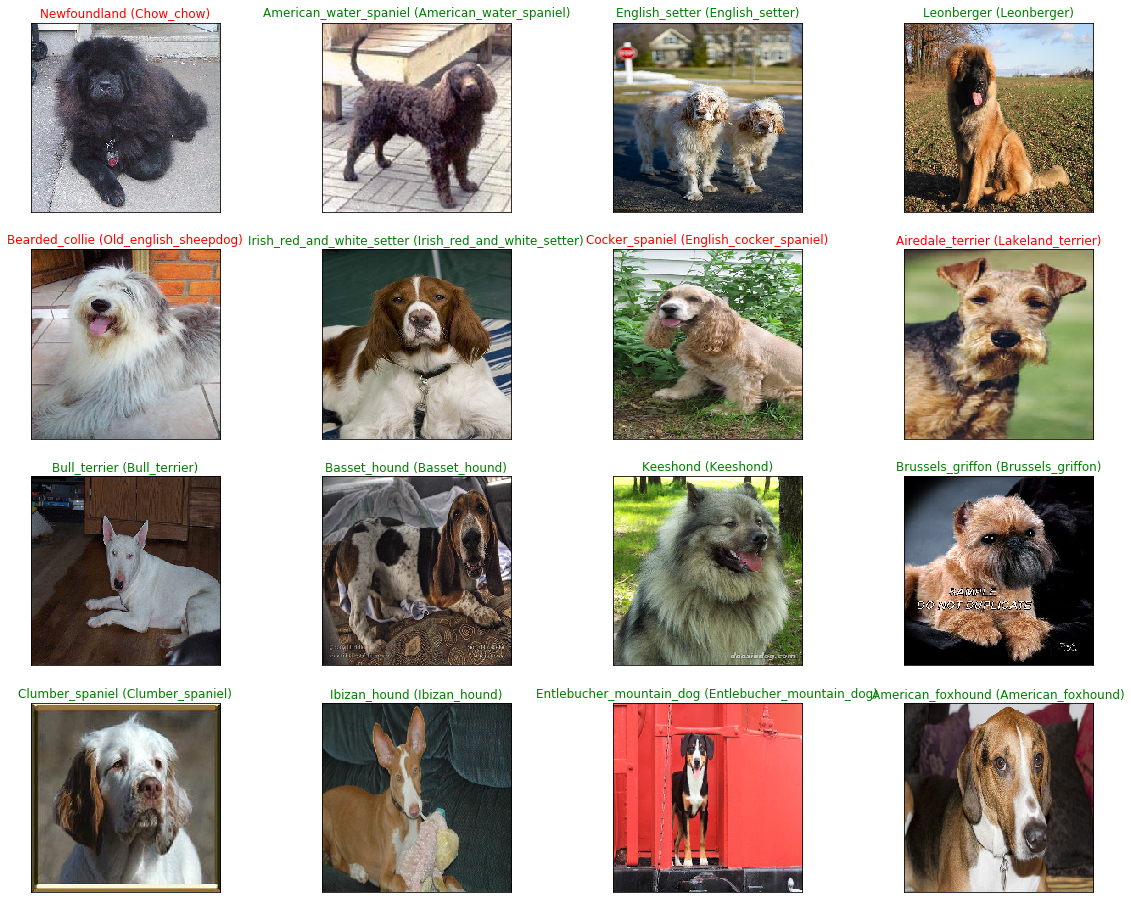

In [42]:
# Here I'm plotting the results obtained with the previous results
fig = plt.figure(figsize=(20, 16))
for i, dog in enumerate(dogs):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
#     ax = fig.add_subplot(2, 4, i + 1)
    ax.imshow(dog[0])
    ax.set_title("{} ({})".format(dog[1], dog[2]), color=("green" if dog[1] == dog[2] else "red"))
plt.show()

---
<a id='step6'></a>
## Step 6: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 5 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [ ]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

`human_model` will predict whether somthing is human or not

- Create a `human_detector(img_path)` function that uses the the VGG human detector to detect humans
- Use the `dog_detector(img_path)` function ti 
- Use the `Resnet50_predict_breed(img_path)` function to classify a dog

To use the `Resnet_predict_breed(img_path)` function a dog must first be detected in the image 

In [43]:
# This function will take and image path and pass it through the network trained in the step 1. 
def human_detector(img_path):
#     Loading the tensor
    tensor = path_to_tensor(img_path).astype('float32')/255
#     Loading bottlenec features
    bottleneck_features = vgg16_model.predict(tensor)
#     Creating label for human category
    categ = to_categorical([1], 2)
#     Passing the image through the network
    predi = human_model.predict(bottleneck_features)
    return np.argmax(categ) == np.argmax(predi)

In [44]:
# This function takes img paths to analyze if there are humans and tell the breed of a dog if any is detected
def classify_images(img_paths):
    processed_files = []

    for img_path in img_paths:
#         Detecting humans
        human_detected = human_detector(img_path)
#       Detecting dogs
        dog_detected = dog_detector(img_path)
#       Trying to detect the breed of the detected dog
        if dog_detected:
            predicted_breed = Resnet50_predict_breed(img_path)

#       Mounting the tittle of the image based on the results of the previous tests
        if not human_detected and not dog_detected:
            img_tittle = 'I know nothing about the photo'
        else:
            if human_detected:
                img_tittle = 'I see a human'
                if  dog_detected:
                    img_tittle = img_tittle + ' and {} {}'.format(('an' if predicted_breed[0] in 'aeiouAEIOU' else 'a'),
                                                                  predicted_breed)
                img_tittle = img_tittle + ' in this photo'
            else:
                img_tittle = 'I see {} {} in this photo'.format(('an' if predicted_breed[0] in 'aeiouAEIOU' else 'a'),
                                                                predicted_breed)

        processed_files.append((img_path, img_tittle))
        
    return processed_files

In this part I'll use the defined functions to predict if there is human or a dog in the photos, and if there is a dog the network will return its breed

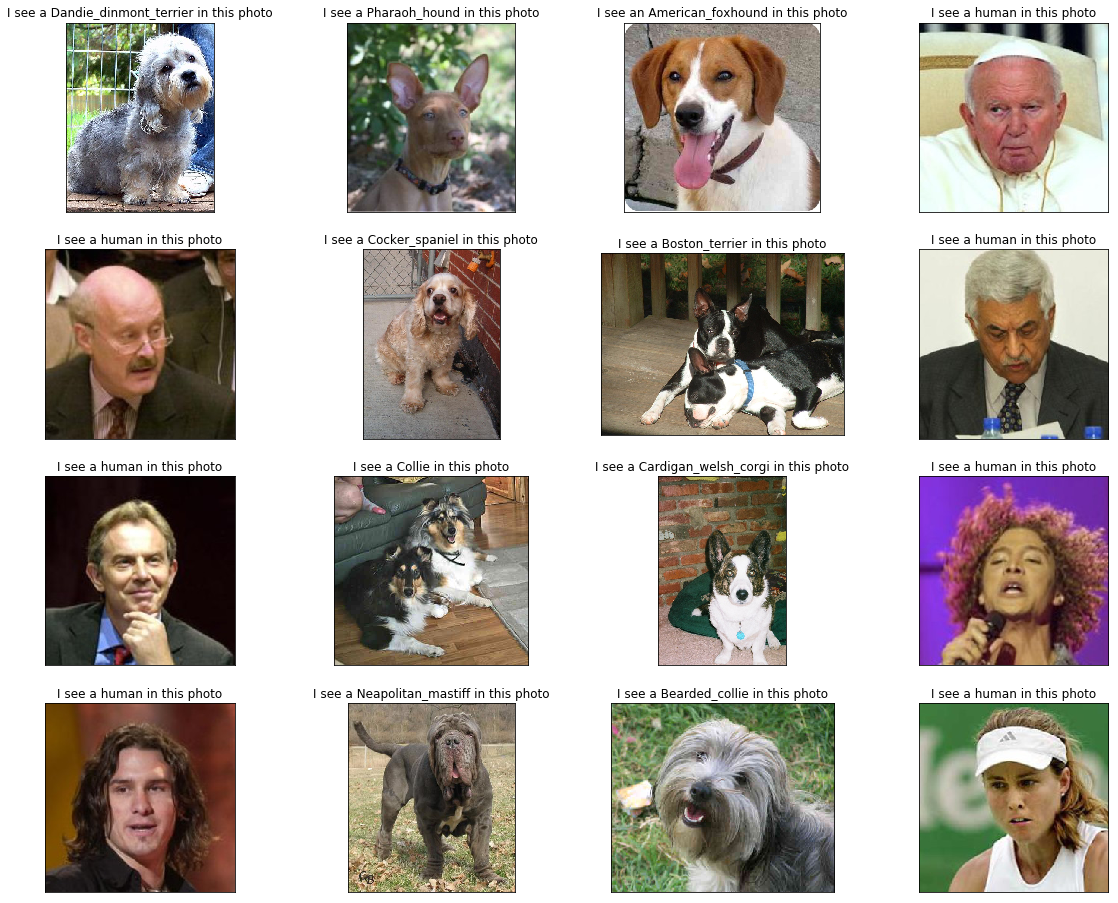

In [45]:
# Concatenating and shuffling 2 testing vectors to use them as inputs to be analyzed in the classify images functions
test_files = np.concatenate((human_files_short, dog_files_short))
random.shuffle(test_files)
num_images = 16

# Classifying images
processed_files = classify_images(test_files[:num_images])

# Calculating the number of row in the image based on the number of analyzed images
num_rows = int(np.ceil(num_images / 4))

fig = plt.figure(figsize=(20, 4 * num_rows))

# Plotting results
for i, (img_pth, img_ttl) in enumerate(processed_files):
    ax = fig.add_subplot(num_rows, 4, i + 1, xticks=[], yticks=[])
    img = plt.imread(img_pth)
    ax.set_title(img_ttl)
    ax.imshow(np.squeeze(img))
plt.show()

---
<a id='step7'></a>
## Step 7: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that __you__ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ 

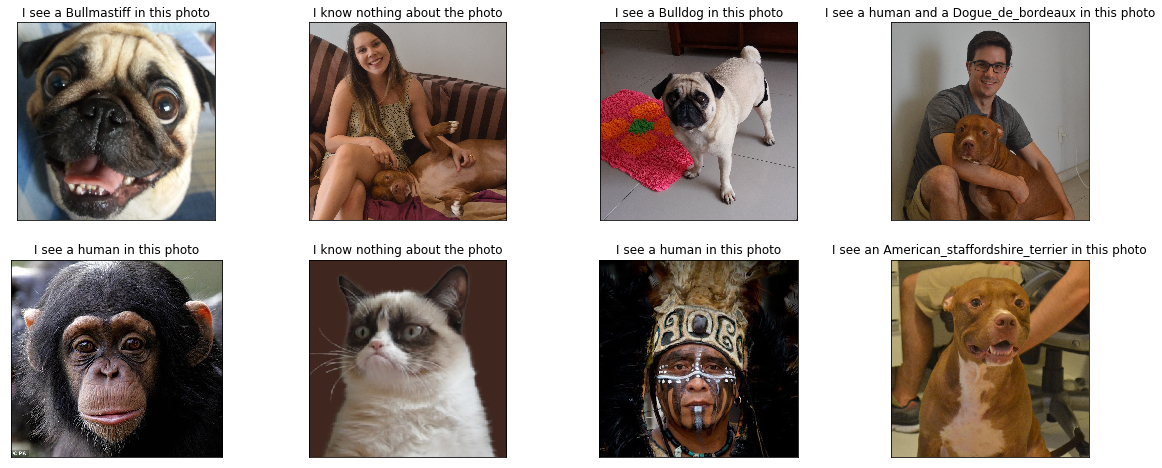

In [46]:
# Loading the images
my_images = np.array(glob("my_images/*"))
my_processed = classify_images(my_images)

# Calculating the number of rows
num_rows = int(np.ceil(len(my_images) / 4))

# Plotting the results
fig = plt.figure(figsize=(20, 4 * num_rows))
for i, (img_pth, img_ttl) in enumerate(my_processed):
    ax = fig.add_subplot(num_rows, 4, i + 1, xticks=[], yticks=[])
    img = plt.imread(img_pth)
    ax.set_title(img_ttl)
    ax.imshow(np.squeeze(img))
plt.show()

The 2 dogs in these photos are Brown and Amy, a Pit Bull and a Pug respectively. The 2 humans in the first row of pictures are I and my girlfriend. 

In the list of images provided there's no images of Pug nor Pit Bulls, so as expected the network could never predict the 
breed of my dogs.

In [47]:
# Looking for pug, american pit bull terrier or pit bull in the names list
for dog_name in dog_names:
    if dog_name.startswith('Pug') or dog_name.startswith('American') or dog_name.startswith('Pit'):
        print(dog_name)

American_eskimo_dog
American_foxhound
American_staffordshire_terrier
American_water_spaniel


Since the machine didn't have any pictures of Pit Bulls nor Pugs, it was expected for it to fail in classifying my dogs. But interesting is that it identified them as dogs, and classified them as breeds that really resembles them

<h4>Dogue de Bordeaux</h4>

<img src='http://d30nr4b2k915ua.cloudfront.net/wp-content/uploads/2015/10/15144316/shutterstock_230446738-thumb1-600x400.jpeg'>

The first 3 images on the 2nd row represent my attempt to make the network fail. As I hoped, the image of the Ape was identified as a human since chimps resembles very much a human being. To avoid this, the network should be trained to reconize apes too, so the chance of this image being an ape would be higher than being a human and the argmax function would return an ape.

As it should be, the network failed to classify grumpy cat because it was never trained to reconize cats.

The last point I'd like to make is that the machine failed to reconize my girlfreind, even with a clear direct picture of her face. At the same time, the network could reconize the mayan warrior with some heavy weird make up. This could be improved by a higher number of images to train the network.

---
## (Opt.) Mutt classifier

Here I'll use the implemented function to classify mutts if a dog is identified in the photo. Percentages of less than 5% will not be considered

In [48]:
def mutt_classifier(img_path):
    '''
    This function takes an image path to a picture and tries to identify a dog in the picture.
    If a dog is identified, then the function for breed identification will be used.
    '''
    
#     Trying to find a dog in the picture
    dog_detected = dog_detector(img_path)
    
    if dog_detected:
        bottleneck_feature = extract_Resnet50(path_to_tensor(img_path))
        predicted_vector = dogBreeds_Resnet50_model.predict(bottleneck_feature)
#         predicted_breed = Resnet50_predict_breed(img_path)
        
#       This list will store the detected breeds
        breeds = []
        
#       Finding the values with 10% or more chance
        for idx, prob in enumerate(predicted_vector[0]):
            if prob >= (5.00 / 100.00):
                breeds.append((prob * 100, idx))
            
#         Sorting the breeds list for better presentation
        breeds.sort(reverse=True)
        
        msg = 'This mutt is: '
        for prob, idx in breeds:
            msg = msg + ' {0:.2f}% {1}\n'.format(prob, dog_names[idx])
            
        return msg
    else:
        return 'I couldn\'t find a dog in this photo'    

### Using the mutt analyzer function

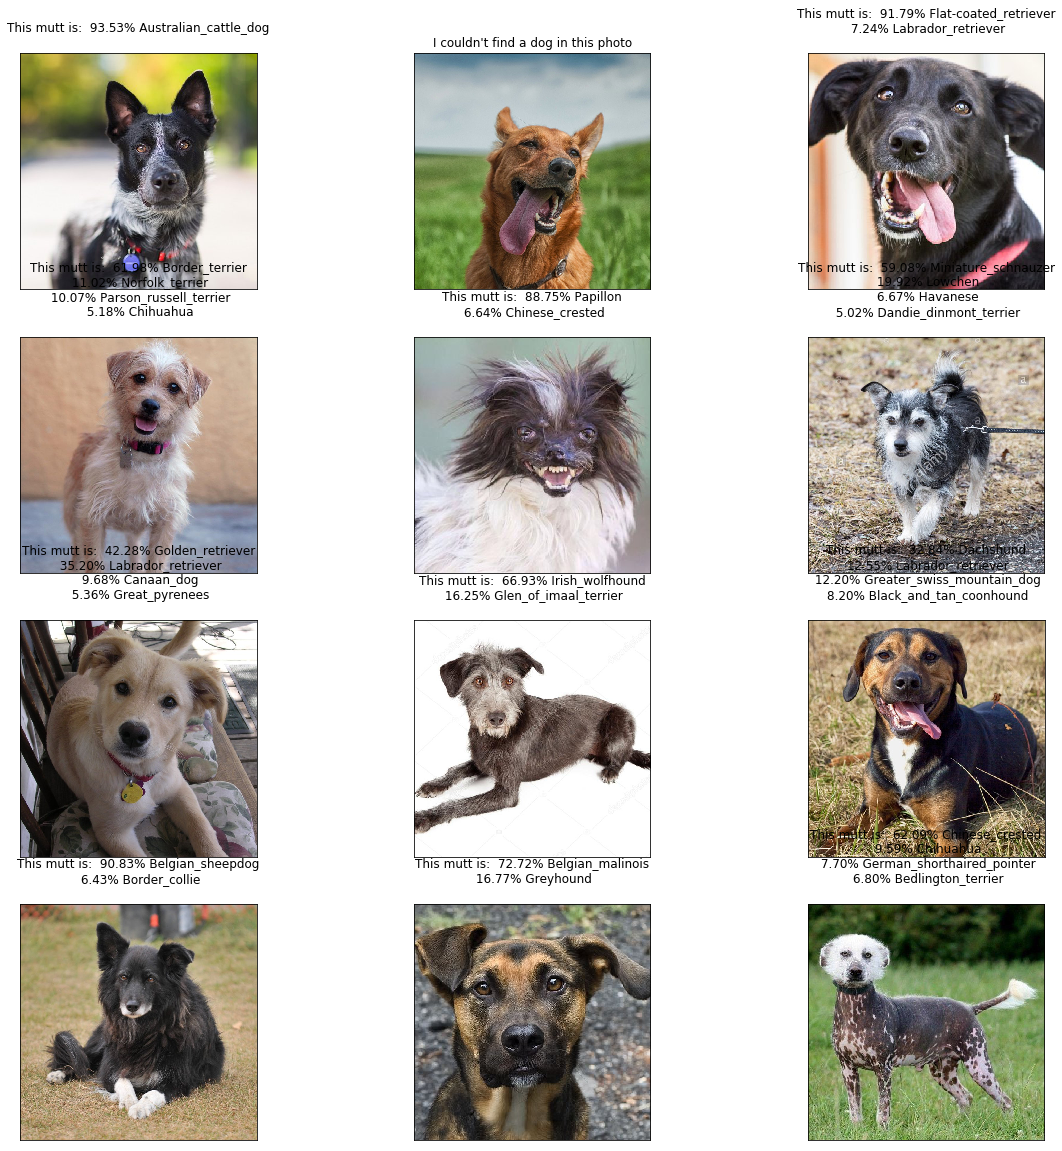

In [49]:
my_images = np.array(glob("my_mutts/*"))

# Calculating the number of rows
num_rows = int(np.ceil(len(my_images) / 3))

# Plotting the results
fig = plt.figure(figsize=(20, 5 * num_rows))
for i, my_image in enumerate(my_images):
    ax = fig.add_subplot(num_rows, 3, i + 1, xticks=[], yticks=[])
    img_ttl = mutt_classifier(my_image)
    img = plt.imread(my_image)
    ax.set_title(img_ttl)
    ax.imshow(np.squeeze(img))
plt.show()